# Import Libraries/files

In [ ]:
#import libraries
import os
import nltk
from nltk.stem import WordNetLemmatizer
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('popular', quiet=True)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('brown')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score,accuracy_score,recall_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

lemmatizer = WordNetLemmatizer()
analyzer = SentimentIntensityAnalyzer()



In [332]:
file_path = "/content/folder"

In [333]:
#getting the list of alll files in the folder
filelist = [file for file in os.listdir(file_path) if not file.startswith('.ipynb_checkpoints') ]
filelist

['Website_dataset_update', 'Speechtotext']

In [334]:
#merging all the web scraping data files
df_sentence = pd.concat([pd.read_csv(file_path + "/" + f) for f in filelist], ignore_index=False)
df_sentence.drop('Unnamed: 0', axis=1, inplace=True)#dropping the unnecessary column
df_sentence

,Text,clean,Sentiment,label
0,"Virtual Reality (VR) use is growing, and the m...",growing medium becoming ever immersive creatin...,positive,1
1,The positive applications of this technology h...,positive application grown popularity,positive,1
2,"One such use-case is VR exposure therapy, wher...",case exposure therapy patient make full unique...,negative,-1
3,"Another is as an educational tool, where VR ha...",another educational tool shown effective promo...,positive,1
4,"However, there is a growing concern that these...",however growing concern immersive property use...,negative,-1
...,...,...,...,...
3136,totally agree,totally agree,positive,1
3137,wrap,wrap,neutral,0
3138,short little episode today,short little episode today,neutral,0
3139,back next episode much deeper blockchain insid...,back next episode much deeper blockchain insid...,neutral,0


# Exploratory Data Analysis

In [335]:
#getting a brief overview of the dataset
df_sentence.describe()

,label
count,6788.000000
mean,0.283441
std,0.707228
min,-1.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [336]:
#checking for null values
df_sentence.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6788 entries, 0 to 3140
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       6788 non-null   object
 1   clean      6727 non-null   object
 2   Sentiment  6788 non-null   object
 3   label      6788 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 265.2+ KB


In [337]:
#checking the shape (rows and columns)
df_sentence.shape

(6788, 4)

In [338]:
# Check for NaN values in each column
nan_values = df_sentence.isna().sum()

# Display columns with NaN values and their counts
print("Columns with NaN values:")
print(nan_values[nan_values > 0])


Columns with NaN values:
clean    61
dtype: int64


In [339]:


# Fill NaN values with an empty string
df_sentence['clean'].fillna('', inplace=True)


In [340]:
#check again to see if all nan values have been replaced
# Check for NaN values in each column
nan_values = df_sentence.isna().sum()

# Display columns with NaN values and their counts
print("Columns with NaN values:")
print(nan_values[nan_values > 0])


Columns with NaN values:
Series([], dtype: int64)


In [400]:
#getting the number of each individual sentiment
sentiments = df_sentence['Sentiment'].value_counts()
sentiments

Sentiment
positive    2932
neutral     2848
negative    1008
Name: count, dtype: int64

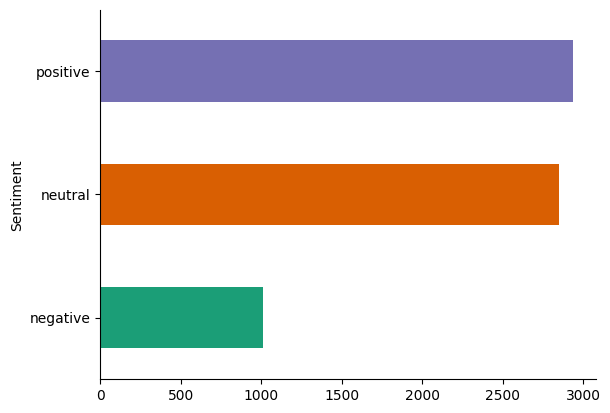

In [341]:
#visualizing the number of the sentiments on a bar plot
from matplotlib import pyplot as plt
import seaborn as sns
df_sentence.groupby('Sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

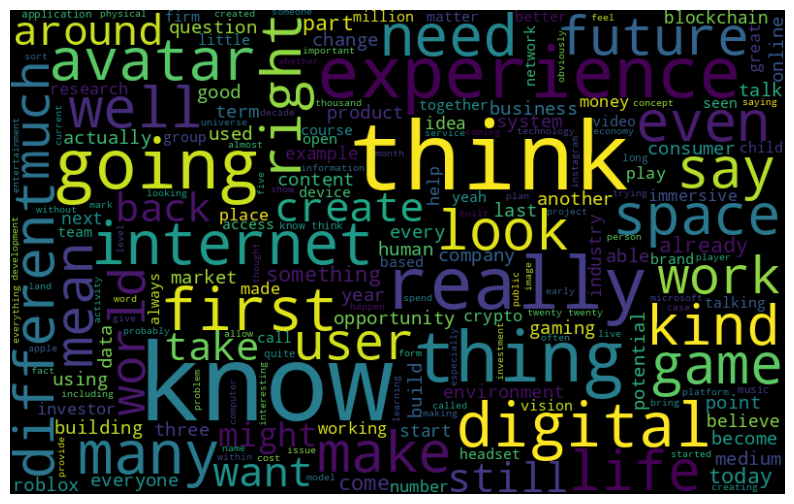

In [342]:
#this is used to know the most important concepts in the dataset
all_words = ' '.join([text for text in df_sentence['clean']])
#The WordCloud library typically expects a single string where words are separated by spaces, and it uses the frequency of each word to generate a word cloud visualization.
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

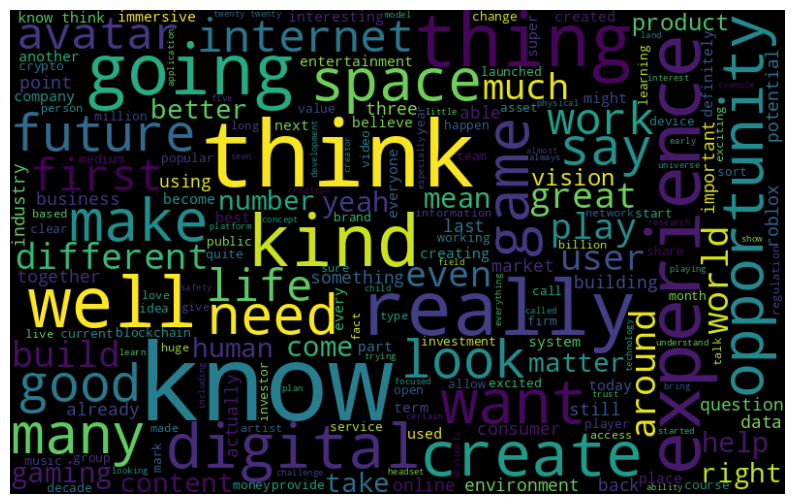

In [343]:
#this is used to visualize the most popular positive words/expressions in the dataset
normal_words_pos =' '.join([text for text in df_sentence['clean'][df_sentence['label'] == 1]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words_pos)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

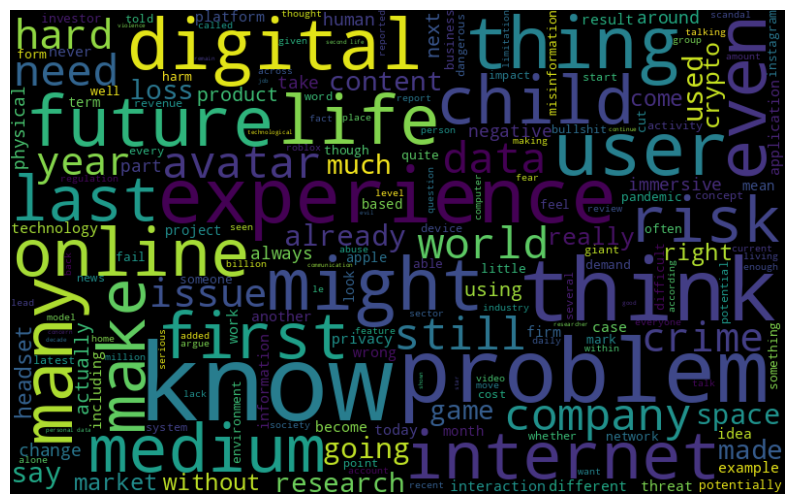

In [344]:
#this is used to visualize the most popular negative words/expressions in the dataset
normal_words_neg =' '.join([text for text in df_sentence['clean'][df_sentence['Sentiment'] == 'negative']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words_neg)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

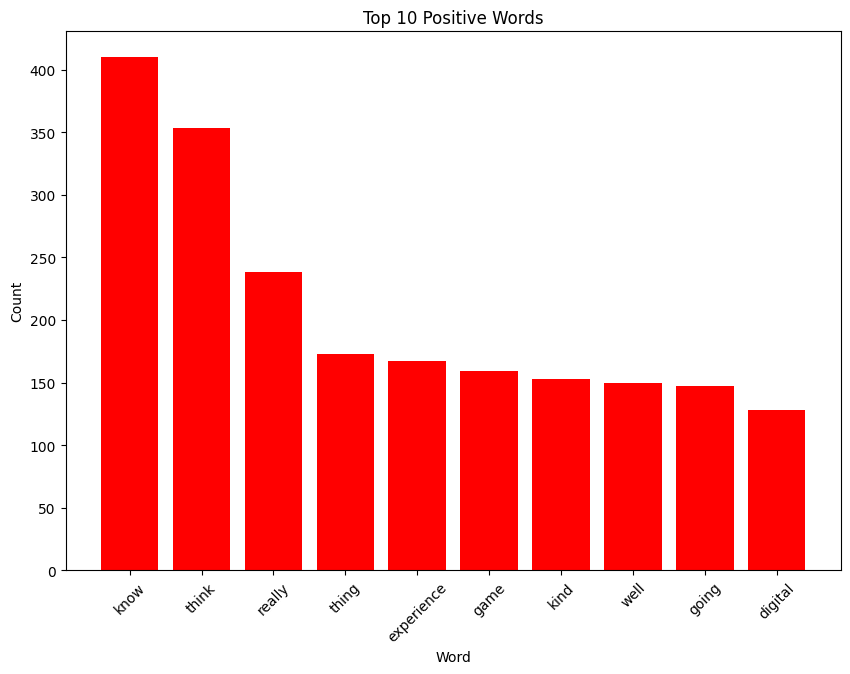

In [345]:
#visualize top 10 positive words
from collections import Counter
import matplotlib.pyplot as plt

# Tokenize the text
words = normal_words_pos.split()

# Count the frequency of each word
word_counts = Counter(words)

# Select the top 10 most frequent positive words
top_positive_words = word_counts.most_common(10)

# Extract words and their counts
positive_words = [word[0] for word in top_positive_words]
counts = [word[1] for word in top_positive_words]

# Plot a bar chart
plt.figure(figsize=(10, 7))
plt.bar(positive_words, counts, color='red')
plt.title('Top 10 Positive Words')
plt.xlabel('Word')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


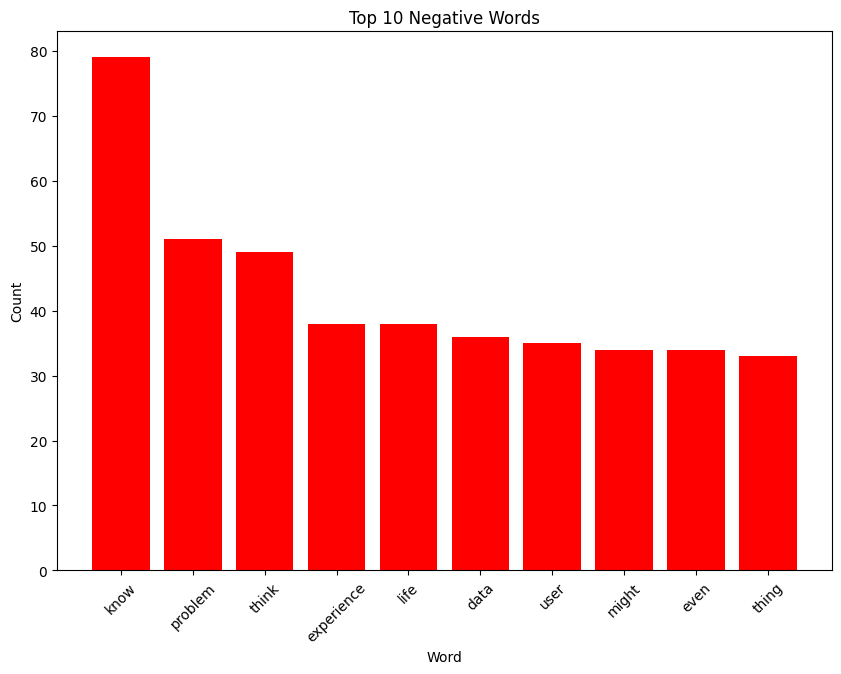

In [346]:
#visualize top 10 negative words
from collections import Counter
import matplotlib.pyplot as plt

# Tokenize the text
words = normal_words_neg.split()

# Count the frequency of each word
word_counts = Counter(words)

# Select the top 10 most frequent negative words
top_negative_words = word_counts.most_common(10)

# Extract words and their counts
negative_words = [word[0] for word in top_negative_words]
counts = [word[1] for word in top_negative_words]

# Plot a bar chart
plt.figure(figsize=(10, 7))
plt.bar(negative_words, counts, color='red')
plt.title('Top 10 Negative Words')
plt.xlabel('Word')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()




# Only run if you want to balance the dataset




In [250]:


# Get the number of negative sentiments
num_negative = 1008

# Sample a subset of positive and neutral sentiments to match the number of negative sentiments
positive_subset = df_sentence[df_sentence['Sentiment'] == 'positive'].sample(n=num_negative, replace=False)
neutral_subset = df_sentence[df_sentence['Sentiment'] == 'neutral'].sample(n=num_negative, replace=False)

# Concatenate the subsets with the negative sentiments
df_sentence = pd.concat([positive_subset, neutral_subset, df_sentence[df_sentence['Sentiment'] == 'negative']])

# Shuffle the rows to mix the sentiments
df_sentence = df_sentence.sample(frac=1).reset_index(drop=True)

# Check the result
print(df_sentence['Sentiment'].value_counts())


Sentiment
negative    1008
neutral     1008
positive    1008
Name: count, dtype: int64


# Machine Learning models

In [347]:
#import libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score,accuracy_score,recall_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
from sklearn import linear_model
import time
from sklearn import svm

# BOW (Bag Of words)

**BOW**

In [401]:
#using bag of words
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=5, max_features=1000, stop_words='english', ngram_range=(1,1))
bow = bow_vectorizer.fit_transform(df_sentence['clean'])
bow = bow.toarray()
bow.shape

(6788, 1000)

**Train: 0.6  Test: 0.4**

In [402]:
#splitting the dataset
xtrain_bow, xvalid_bow, ytrain_bow, yvalid_bow = train_test_split(bow, df_sentence['label'],random_state=42,test_size=0.4)



In [403]:
#using naive-bayes classifier
gnb = GaussianNB()
gnb.fit(xtrain_bow, ytrain_bow)
pred = gnb.predict(xvalid_bow)
accNB_4 = accuracy_score(yvalid_bow, pred)
y_pred_prob = gnb.predict_proba(xvalid_bow)

print("Confusion matrix")
#print(confusion_matrix(yvalid,pred))
print(classification_report(yvalid_bow, pred))
#print("AUC score for NB is ",aucScoreBOW)
predT=gnb.predict(xtrain_bow)
f1 = f1_score(yvalid_bow, pred, average='macro')
# Round the F1 score to two decimal places
rounded_f1 = round(f1, 2)
# Print F1 score
print("Overall F1 score is ", rounded_f1)

# Calculate accuracy
rounded_acc = round(accNB_4, 2)
# Print accuracy
print("Accuracy is ", rounded_acc)

Confusion matrix
              precision    recall  f1-score   support

          -1       0.19      0.66      0.29       408
           0       0.73      0.43      0.55      1174
           1       0.82      0.41      0.55      1134

    accuracy                           0.46      2716
   macro avg       0.58      0.50      0.46      2716
weighted avg       0.69      0.46      0.51      2716

Overall F1 score is  0.46
Accuracy is  0.46


In [404]:
# Perform classification with SVM, OneVRestClassifier, kernel=rbf
svc = svm.SVC(kernel='rbf')
o_vs_r = OneVsRestClassifier(svc)
t0 = time.time()
o_vs_r.fit(xtrain_bow, ytrain_bow)
t1 = time.time()
prediction_linear = o_vs_r.predict(xvalid_bow)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1
accSVM_4 = accuracy_score(yvalid_bow, prediction_linear)
# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
report = classification_report(yvalid_bow, prediction_linear)
predT=o_vs_r.predict(xtrain_bow)
print(report)
f1 = f1_score(yvalid_bow, prediction_linear, average='macro')
# Round the F1 score to two decimal places
rounded_f1 = round(f1, 2)
# Print F1 score
print("Overall F1 score is ", rounded_f1)

# Calculate accuracy
rounded_acc = round(accSVM_4, 2)
# Print accuracy
print("Accuracy is ", rounded_acc)

Training time: 39.483561s; Prediction time: 31.066909s
              precision    recall  f1-score   support

          -1       0.94      0.17      0.28       408
           0       0.71      0.87      0.78      1174
           1       0.74      0.79      0.77      1134

    accuracy                           0.73      2716
   macro avg       0.80      0.61      0.61      2716
weighted avg       0.76      0.73      0.70      2716

Overall F1 score is  0.61
Accuracy is  0.73


In [405]:
#using L0gistic Regression
lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(xtrain_bow, ytrain_bow)
pred = lm.predict(xvalid_bow)
acclm_4 = accuracy_score(yvalid_bow, pred)
y_pred_prob = lm.predict_proba(xvalid_bow)

print("Confusion matrix")
#print(confusion_matrix(yvalid,pred))
print(classification_report(yvalid_bow, pred))
f1 = f1_score(yvalid_bow, pred, average='macro')
# Round the F1 score to two decimal places
rounded_f1 = round(f1, 2)
# Print F1 score
print("Overall F1 score is ", rounded_f1)

# Calculate accuracy
rounded_acc = round(acclm_4, 2)
# Print accuracy
print("Accuracy is ", rounded_acc)

Confusion matrix
              precision    recall  f1-score   support

          -1       0.68      0.28      0.40       408
           0       0.71      0.90      0.80      1174
           1       0.80      0.75      0.78      1134

    accuracy                           0.75      2716
   macro avg       0.73      0.65      0.66      2716
weighted avg       0.75      0.75      0.73      2716

Overall F1 score is  0.66
Accuracy is  0.75


In [406]:
#using Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
model = RandomForestClassifier(random_state=42, n_jobs=-1,  oob_score=True,
                                       n_estimators=200)
model.fit(xtrain_bow, ytrain_bow)
# Predict on validation data
pred = model.predict(xvalid_bow)

# Calculate accuracy
accrf_4 = accuracy_score(yvalid_bow, pred)

# Print classification report and other metrics
print("Confusion matrix")
print(classification_report(yvalid_bow, pred))
predT = lm.predict(xtrain_bow)
# Calculate F1 score
f1 = f1_score(yvalid_bow, pred, average='macro')
# Round the F1 score to two decimal places
rounded_f1 = round(f1, 2)
# Print F1 score
print("Overall F1 score for Random Forest Classifier is ", rounded_f1)
from sklearn.metrics import accuracy_score

# Calculate accuracy
rounded_acc = round(accrf_4, 2)
# Print accuracy
print("Accuracy for Random Forest Classifier is ", rounded_acc)

Confusion matrix
              precision    recall  f1-score   support

          -1       0.53      0.39      0.45       408
           0       0.74      0.82      0.78      1174
           1       0.79      0.79      0.79      1134

    accuracy                           0.74      2716
   macro avg       0.69      0.66      0.67      2716
weighted avg       0.73      0.74      0.73      2716

Overall F1 score for Random Forest Classifier is  0.67
Accuracy for Random Forest Classifier is  0.74


Train: 0.7 Test: 0.3

In [407]:
#splitting the dataset
xtrain_bow, xvalid_bow, ytrain_bow, yvalid_bow = train_test_split(bow, df_sentence['label'],random_state=42,test_size=0.3)



In [ ]:
#using naive-bayes classifier
gnb = GaussianNB()
gnb.fit(xtrain_bow, ytrain_bow)
pred = gnb.predict(xvalid_bow)
accNB_3 = accuracy_score(yvalid_bow, pred)
y_pred_prob = gnb.predict_proba(xvalid_bow)

print("Confusion matrix")
#print(confusion_matrix(yvalid,pred))
print(classification_report(yvalid_bow, pred))
#print("AUC score for NB is ",aucScoreBOW)
predT=gnb.predict(xtrain_bow)
f1 = f1_score(yvalid_bow, pred, average='macro')
# Round the F1 score to two decimal places
rounded_f1 = round(f1, 2)
# Print F1 score
print("Overall F1 score is ", rounded_f1)

# Calculate accuracy
rounded_acc = round(accNB_3, 2)
# Print accuracy
print("Accuracy is ", rounded_acc)

In [ ]:
# Perform classification with SVM, OneVRestClassifier, kernel=rbf
svc = svm.SVC(kernel='rbf')
o_vs_r = OneVsRestClassifier(svc)
t0 = time.time()
o_vs_r.fit(xtrain_bow, ytrain_bow)
t1 = time.time()
prediction_linear = o_vs_r.predict(xvalid_bow)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1
accSVM_3 = accuracy_score(yvalid_bow, prediction_linear)
# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
report = classification_report(yvalid_bow, prediction_linear)
predT=o_vs_r.predict(xtrain_bow)
print(report)
f1 = f1_score(yvalid_bow, prediction_linear, average='macro')
# Round the F1 score to two decimal places
rounded_f1 = round(f1, 2)
# Print F1 score
print("Overall F1 score is ", rounded_f1)

# Calculate accuracy
rounded_acc = round(accSVM_3, 2)
# Print accuracy
print("Accuracy is ", rounded_acc)

In [ ]:
#using L0gistic Regression
lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(xtrain_bow, ytrain_bow)
pred = lm.predict(xvalid_bow)
acclm_3 = accuracy_score(yvalid_bow, pred)
y_pred_prob = lm.predict_proba(xvalid_bow)

print("Confusion matrix")
#print(confusion_matrix(yvalid,pred))
print(classification_report(yvalid_bow, pred))
f1 = f1_score(yvalid_bow, pred, average='macro')
# Round the F1 score to two decimal places
rounded_f1 = round(f1, 2)
# Print F1 score
print("Overall F1 score is ", rounded_f1)

# Calculate accuracy
rounded_acc = round(acclm_3, 2)
# Print accuracy
print("Accuracy is ", rounded_acc)

In [ ]:
#using Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
model = RandomForestClassifier(random_state=42, n_jobs=-1,  oob_score=True,
                                       n_estimators=200)
model.fit(xtrain_bow, ytrain_bow)
# Predict on validation data
pred = model.predict(xvalid_bow)

# Calculate accuracy
accrf_3 = accuracy_score(yvalid_bow, pred)

# Print classification report and other metrics
print("Confusion matrix")
print(classification_report(yvalid_bow, pred))
predT = lm.predict(xtrain_bow)
# Calculate F1 score
f1 = f1_score(yvalid_bow, pred, average='macro')
# Round the F1 score to two decimal places
rounded_f1 = round(f1, 2)
# Print F1 score
print("Overall F1 score for Random Forest Classifier is ", rounded_f1)
from sklearn.metrics import accuracy_score

# Calculate accuracy
rounded_acc = round(accrf_3, 2)
# Print accuracy
print("Accuracy for Random Forest Classifier is ", rounded_acc)

Train: 0.8 Test: 0.2

In [412]:
#splitting the dataset
xtrain_bow, xvalid_bow, ytrain_bow, yvalid_bow = train_test_split(bow, df_sentence['label'],random_state=42,test_size=0.2)



In [ ]:
#using naive-bayes classifier
gnb = GaussianNB()
gnb.fit(xtrain_bow, ytrain_bow)
pred = gnb.predict(xvalid_bow)
accNB_2 = accuracy_score(yvalid_bow, pred)
y_pred_prob = gnb.predict_proba(xvalid_bow)

print("Confusion matrix")
#print(confusion_matrix(yvalid,pred))
print(classification_report(yvalid_bow, pred))
#print("AUC score for NB is ",aucScoreBOW)
predT=gnb.predict(xtrain_bow)
f1 = f1_score(yvalid_bow, pred, average='macro')
# Round the F1 score to two decimal places
rounded_f1 = round(f1, 2)
# Print F1 score
print("Overall F1 score is ", rounded_f1)

# Calculate accuracy
rounded_acc = round(accNB_2, 2)
# Print accuracy
print("Accuracy is ", rounded_acc)

In [ ]:
# Perform classification with SVM, OneVRestClassifier, kernel=rbf
svc = svm.SVC(kernel='rbf')
o_vs_r = OneVsRestClassifier(svc)
t0 = time.time()
o_vs_r.fit(xtrain_bow, ytrain_bow)
t1 = time.time()
prediction_linear = o_vs_r.predict(xvalid_bow)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1
accSVM_2 = accuracy_score(yvalid_bow, prediction_linear)
# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
report = classification_report(yvalid_bow, prediction_linear)
predT=o_vs_r.predict(xtrain_bow)
print(report)
f1 = f1_score(yvalid_bow, prediction_linear, average='macro')
# Round the F1 score to two decimal places
rounded_f1 = round(f1, 2)
# Print F1 score
print("Overall F1 score is ", rounded_f1)

# Calculate accuracy
rounded_acc = round(accSVM_2, 2)
# Print accuracy
print("Accuracy is ", rounded_acc)

In [ ]:
#using L0gistic Regression
lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(xtrain_bow, ytrain_bow)
pred = lm.predict(xvalid_bow)
acclm_2 = accuracy_score(yvalid_bow, pred)
y_pred_prob = lm.predict_proba(xvalid_bow)

print("Confusion matrix")
#print(confusion_matrix(yvalid,pred))
print(classification_report(yvalid_bow, pred))
f1 = f1_score(yvalid_bow, pred, average='macro')
# Round the F1 score to two decimal places
rounded_f1 = round(f1, 2)
# Print F1 score
print("Overall F1 score is ", rounded_f1)

# Calculate accuracy
rounded_acc = round(acclm_2, 2)
# Print accuracy
print("Accuracy is ", rounded_acc)

In [ ]:
#using Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
model = RandomForestClassifier(random_state=42, n_jobs=-1,  oob_score=True,
                                       n_estimators=200)
model.fit(xtrain_bow, ytrain_bow)
# Predict on validation data
pred = model.predict(xvalid_bow)

# Calculate accuracy
accrf_2 = accuracy_score(yvalid_bow, pred)

# Print classification report and other metrics
print("Confusion matrix")
print(classification_report(yvalid_bow, pred))
predT = lm.predict(xtrain_bow)
# Calculate F1 score
f1 = f1_score(yvalid_bow, pred, average='macro')
# Round the F1 score to two decimal places
rounded_f1 = round(f1, 2)
# Print F1 score
print("Overall F1 score for Random Forest Classifier is ", rounded_f1)
from sklearn.metrics import accuracy_score

# Calculate accuracy
rounded_acc = round(accrf_2, 2)
# Print accuracy
print("Accuracy for Random Forest Classifier is ", rounded_acc)

**Train: 0.9 Test: 0.1**

In [417]:
#splitting the dataset
xtrain_bow, xvalid_bow, ytrain_bow, yvalid_bow = train_test_split(bow, df_sentence['label'],random_state=42,test_size=0.1)



In [ ]:
#using naive-bayes classifier
gnb = GaussianNB()
gnb.fit(xtrain_bow, ytrain_bow)
pred = gnb.predict(xvalid_bow)
accNB_1 = accuracy_score(yvalid_bow, pred)
y_pred_prob = gnb.predict_proba(xvalid_bow)

print("Confusion matrix")
#print(confusion_matrix(yvalid,pred))
print(classification_report(yvalid_bow, pred))
#print("AUC score for NB is ",aucScoreBOW)
predT=gnb.predict(xtrain_bow)
f1 = f1_score(yvalid_bow, pred, average='macro')
# Round the F1 score to two decimal places
rounded_f1 = round(f1, 2)
# Print F1 score
print("Overall F1 score is ", rounded_f1)

# Calculate accuracy
rounded_acc = round(accNB_1, 2)
# Print accuracy
print("Accuracy is ", rounded_acc)

In [ ]:
# Perform classification with SVM, OneVRestClassifier, kernel=rbf
svc = svm.SVC(kernel='rbf')
o_vs_r = OneVsRestClassifier(svc)
t0 = time.time()
o_vs_r.fit(xtrain_bow, ytrain_bow)
t1 = time.time()
prediction_linear = o_vs_r.predict(xvalid_bow)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1
accSVM_1 = accuracy_score(yvalid_bow, prediction_linear)
# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
report = classification_report(yvalid_bow, prediction_linear)
predT=o_vs_r.predict(xtrain_bow)
print(report)
f1 = f1_score(yvalid_bow, prediction_linear, average='macro')
# Round the F1 score to two decimal places
rounded_f1 = round(f1, 2)
# Print F1 score
print("Overall F1 score is ", rounded_f1)

# Calculate accuracy
rounded_acc = round(accSVM_1, 2)
# Print accuracy
print("Accuracy is ", rounded_acc)

In [ ]:
#using L0gistic Regression
lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(xtrain_bow, ytrain_bow)
pred = lm.predict(xvalid_bow)
acclm_1 = accuracy_score(yvalid_bow, pred)
y_pred_prob = lm.predict_proba(xvalid_bow)

print("Confusion matrix")
#print(confusion_matrix(yvalid,pred))
print(classification_report(yvalid_bow, pred))
f1 = f1_score(yvalid_bow, pred, average='macro')
# Round the F1 score to two decimal places
rounded_f1 = round(f1, 2)
# Print F1 score
print("Overall F1 score is ", rounded_f1)

# Calculate accuracy
rounded_acc = round(acclm_1, 2)
# Print accuracy
print("Accuracy is ", rounded_acc)

In [ ]:
#using Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
model = RandomForestClassifier(random_state=42, n_jobs=-1,  oob_score=True,
                                       n_estimators=200)
model.fit(xtrain_bow, ytrain_bow)
# Predict on validation data
pred = model.predict(xvalid_bow)

# Calculate accuracy
accrf_1 = accuracy_score(yvalid_bow, pred)

# Print classification report and other metrics
print("Confusion matrix")
print(classification_report(yvalid_bow, pred))
predT = lm.predict(xtrain_bow)
# Calculate F1 score
f1 = f1_score(yvalid_bow, pred, average='macro')
# Round the F1 score to two decimal places
rounded_f1 = round(f1, 2)
# Print F1 score
print("Overall F1 score for Random Forest Classifier is ", rounded_f1)
from sklearn.metrics import accuracy_score

# Calculate accuracy
rounded_acc = round(accrf_1, 2)
# Print accuracy
print("Accuracy for Random Forest Classifier is ", rounded_acc)

**Data visualization: bar plot comparing the accuracy of each model in each test split**

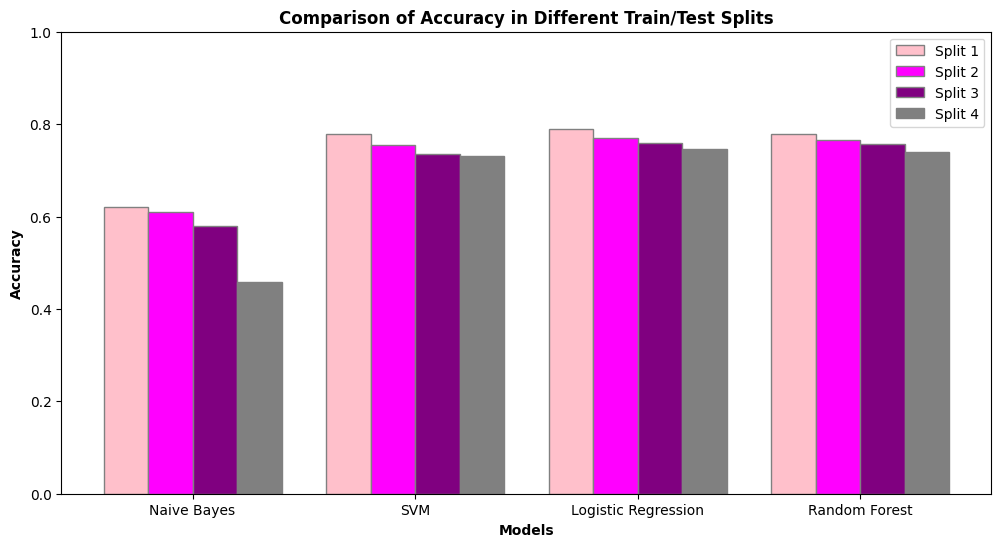

In [422]:


# Accuracy scores for each model in each train/test split
train_test_split_1 = [accNB_1, accSVM_1, acclm_1, accrf_1]
train_test_split_2 = [accNB_2, accSVM_2, acclm_2, accrf_2]
train_test_split_3 = [accNB_3, accSVM_3, acclm_3, accrf_3]
train_test_split_4 = [accNB_4, accSVM_4, acclm_4, accrf_4]

# Labels for models
models = ['Naive Bayes', 'SVM', 'Logistic Regression', 'Random Forest']

# Set the width of the bars
bar_width = 0.2

# Set position of bar on X axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Plotting accuracy scores for each train/test split
plt.figure(figsize=(12, 6))
plt.bar(r1, train_test_split_1, color='pink', width=bar_width, edgecolor='grey', label='Split 1')
plt.bar(r2, train_test_split_2, color='magenta', width=bar_width, edgecolor='grey', label='Split 2')
plt.bar(r3, train_test_split_3, color='purple', width=bar_width, edgecolor='grey', label='Split 3')
plt.bar(r4, train_test_split_4, color='grey', width=bar_width, edgecolor='grey', label='Split 4')

plt.xlabel('Models', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.xticks([r + 1.5 * bar_width for r in range(len(models))], models)
plt.title('Comparison of Accuracy in Different Train/Test Splits', fontweight='bold')
plt.legend()
plt.ylim(0, 1)  # Setting y-axis limit to be between 0 and 1 for better visualization
plt.show()


# TF-IDF

**TF-IDF**

In [370]:
#using tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=5, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df_sentence['clean'])
tfidf = tfidf.toarray()
tfidf.shape

(6788, 1000)

**Tain: 0.6 Test: 0.4**

In [371]:
#splitting the dataset
xtrain_tfidf, xvalid_tfidf, ytrain_tfidf, yvalid_tfidf = train_test_split(tfidf, df_sentence['label'],random_state=42,test_size=0.4)



In [372]:
#using naive-bayes classifier
gnb = GaussianNB()
gnb.fit(xtrain_tfidf, ytrain_tfidf)
pred = gnb.predict(xvalid_tfidf)
accNB_tfidf_4 = accuracy_score(yvalid_tfidf, pred)
y_pred_prob = gnb.predict_proba(xvalid_tfidf)

print("Confusion matrix")
#print(confusion_matrix(yvalid,pred))
print(classification_report(yvalid_tfidf, pred))
#print("AUC score for NB is ",aucScoreBOW)
predT=gnb.predict(xtrain_tfidf)

# Calculate accuracy
accuracy = accuracy_score(yvalid_tfidf, pred)
rounded_acc = round(accNB_tfidf_4, 2)
# Print accuracy
print("Accuracy is ",rounded_acc)

Confusion matrix
              precision    recall  f1-score   support

          -1       0.19      0.63      0.29       408
           0       0.73      0.47      0.57      1174
           1       0.81      0.44      0.57      1134

    accuracy                           0.48      2716
   macro avg       0.58      0.51      0.48      2716
weighted avg       0.68      0.48      0.53      2716

Accuracy is  0.48


In [ ]:
# Perform classification with SVM, OneVRestClassifier, kernel=rbf
svc = svm.SVC(kernel='rbf')
o_vs_r = OneVsRestClassifier(svc)
t0 = time.time()
o_vs_r.fit(xtrain_tfidf, ytrain_tfidf)
t1 = time.time()
prediction_linear = o_vs_r.predict(xvalid_tfidf)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1
accSVM_tfidf_4 = accuracy_score(yvalid_tfidf, prediction_linear)
# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
report = classification_report(yvalid_tfidf, prediction_linear)
predT=o_vs_r.predict(xtrain_tfidf)
 #Calculate F1 score
f1 = f1_score(yvalid_tfidf, prediction_linear, average='macro')
# Round the F1 score to two decimal places
rounded_f1 = round(f1, 2)
# Print F1 score
print("Overall F1 score is ", rounded_f1)
from sklearn.metrics import accuracy_score

# Calculate accuracy
rounded_acc = round(accSVM_tfidf_4, 2)
# Print accuracy
print("Accuracy is ", rounded_acc)
print(report)


In [ ]:
#using Logistic Regression
lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(xtrain_tfidf, ytrain_tfidf)
pred = lm.predict(xvalid_tfidf)
acclm_tfidf_4 = accuracy_score(yvalid_tfidf, pred)
y_pred_prob = lm.predict_proba(xvalid_tfidf)

print("Confusion matrix")
#print(confusion_matrix(yvalid,pred))
print(classification_report(yvalid_tfidf, pred))

f1 = f1_score(yvalid_tfidf, pred, average='macro')
# Round the F1 score to two decimal places
rounded_f1 = round(f1, 2)
# Print F1 score
print("Overall F1 score is ", rounded_f1)

# Calculate accuracy
rounded_acc = round(acclm_tfidf_4, 2)
# Print accuracy
print("Accuracy is ", rounded_acc)


In [ ]:
#using Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42, n_jobs=-1,  oob_score=True,
                                       n_estimators=200)
model.fit(xtrain_tfidf, ytrain_tfidf)
# Predict on validation data
pred = model.predict(xvalid_tfidf)

# Calculate accuracy
accrf_tfidf_4 = accuracy_score(yvalid_tfidf, pred)

# Print classification report and other metrics
print("Confusion matrix")
print(classification_report(yvalid_tfidf, pred))
predT = lm.predict(xtrain_tfidf)

f1 = f1_score(yvalid_tfidf, pred, average='macro')
# Round the F1 score to two decimal places
rounded_f1 = round(f1, 2)
# Print F1 score
print("Overall F1 score is ", rounded_f1)

# Calculate accuracy
rounded_acc = round(accrf_tfidf_4, 2)
# Print accuracy
print("Accuracy is ", rounded_acc)

**Train: 0.7 Test: 0.3**

In [376]:
#splitting the dataset
xtrain_tfidf, xvalid_tfidf, ytrain_tfidf, yvalid_tfidf = train_test_split(tfidf, df_sentence['label'],random_state=42,test_size=0.3)



In [ ]:
#using naive-bayes classifier
gnb = GaussianNB()
gnb.fit(xtrain_tfidf, ytrain_tfidf)
pred = gnb.predict(xvalid_tfidf)
accNB_tfidf_3 = accuracy_score(yvalid_tfidf, pred)
y_pred_prob = gnb.predict_proba(xvalid_tfidf)

print("Confusion matrix")
#print(confusion_matrix(yvalid,pred))
print(classification_report(yvalid_tfidf, pred))
#print("AUC score for NB is ",aucScoreBOW)
predT=gnb.predict(xtrain_tfidf)

# Calculate accuracy
accuracy = accuracy_score(yvalid_tfidf, pred)
rounded_acc = round(accNB_tfidf_3, 2)
# Print accuracy
print("Accuracy is ",rounded_acc)

In [ ]:
# Perform classification with SVM, OneVRestClassifier, kernel=rbf
svc = svm.SVC(kernel='rbf')
o_vs_r = OneVsRestClassifier(svc)
t0 = time.time()
o_vs_r.fit(xtrain_tfidf, ytrain_tfidf)
t1 = time.time()
prediction_linear = o_vs_r.predict(xvalid_tfidf)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1
accSVM_tfidf_3 = accuracy_score(yvalid_tfidf, prediction_linear)
# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
report = classification_report(yvalid_tfidf, prediction_linear)
predT=o_vs_r.predict(xtrain_tfidf)
 #Calculate F1 score
f1 = f1_score(yvalid_tfidf, prediction_linear, average='macro')
# Round the F1 score to two decimal places
rounded_f1 = round(f1, 2)
# Print F1 score
print("Overall F1 score is ", rounded_f1)
from sklearn.metrics import accuracy_score

# Calculate accuracy
rounded_acc = round(accSVM_tfidf_3, 2)
# Print accuracy
print("Accuracy is ", rounded_acc)
print(report)


In [ ]:
#using Logistic Regression
lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(xtrain_tfidf, ytrain_tfidf)
pred = lm.predict(xvalid_tfidf)
acclm_tfidf_3 = accuracy_score(yvalid_tfidf, pred)
y_pred_prob = lm.predict_proba(xvalid_tfidf)

print("Confusion matrix")
#print(confusion_matrix(yvalid,pred))
print(classification_report(yvalid_tfidf, pred))

f1 = f1_score(yvalid_tfidf, pred, average='macro')
# Round the F1 score to two decimal places
rounded_f1 = round(f1, 2)
# Print F1 score
print("Overall F1 score is ", rounded_f1)

# Calculate accuracy
rounded_acc = round(acclm_tfidf_3, 2)
# Print accuracy
print("Accuracy is ", rounded_acc)


In [ ]:
#using Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42, n_jobs=-1,  oob_score=True,
                                       n_estimators=200)
model.fit(xtrain_tfidf, ytrain_tfidf)
# Predict on validation data
pred = model.predict(xvalid_tfidf)

# Calculate accuracy
accrf_tfidf_3 = accuracy_score(yvalid_tfidf, pred)

# Print classification report and other metrics
print("Confusion matrix")
print(classification_report(yvalid_tfidf, pred))
predT = lm.predict(xtrain_tfidf)

f1 = f1_score(yvalid_tfidf, pred, average='macro')
# Round the F1 score to two decimal places
rounded_f1 = round(f1, 2)
# Print F1 score
print("Overall F1 score is ", rounded_f1)

# Calculate accuracy
rounded_acc = round(accrf_tfidf_3, 2)
# Print accuracy
print("Accuracy is ", rounded_acc)

**Train: 0.8 Test: 0.2**

In [381]:
#splitting the dataset
xtrain_tfidf, xvalid_tfidf, ytrain_tfidf, yvalid_tfidf = train_test_split(tfidf, df_sentence['label'],random_state=42,test_size=0.2)



In [ ]:
#using naive-bayes classifier
gnb = GaussianNB()
gnb.fit(xtrain_tfidf, ytrain_tfidf)
pred = gnb.predict(xvalid_tfidf)
accNB_tfidf_2 = accuracy_score(yvalid_tfidf, pred)
y_pred_prob = gnb.predict_proba(xvalid_tfidf)

print("Confusion matrix")
#print(confusion_matrix(yvalid,pred))
print(classification_report(yvalid_tfidf, pred))
#print("AUC score for NB is ",aucScoreBOW)
predT=gnb.predict(xtrain_tfidf)

# Calculate accuracy
accuracy = accuracy_score(yvalid_tfidf, pred)
rounded_acc = round(accNB_tfidf_2, 2)
# Print accuracy
print("Accuracy is ",rounded_acc)

In [ ]:
# Perform classification with SVM, OneVRestClassifier, kernel=rbf
svc = svm.SVC(kernel='rbf')
o_vs_r = OneVsRestClassifier(svc)
t0 = time.time()
o_vs_r.fit(xtrain_tfidf, ytrain_tfidf)
t1 = time.time()
prediction_linear = o_vs_r.predict(xvalid_tfidf)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1
accSVM_tfidf_2 = accuracy_score(yvalid_tfidf, prediction_linear)
# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
report = classification_report(yvalid_tfidf, prediction_linear)
predT=o_vs_r.predict(xtrain_tfidf)
 #Calculate F1 score
f1 = f1_score(yvalid_tfidf, prediction_linear, average='macro')
# Round the F1 score to two decimal places
rounded_f1 = round(f1, 2)
# Print F1 score
print("Overall F1 score is ", rounded_f1)
from sklearn.metrics import accuracy_score

# Calculate accuracy
rounded_acc = round(accSVM_tfidf_2, 2)
# Print accuracy
print("Accuracy is ", rounded_acc)
print(report)


In [ ]:
#using Logistic Regression
lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(xtrain_tfidf, ytrain_tfidf)
pred = lm.predict(xvalid_tfidf)
acclm_tfidf_2 = accuracy_score(yvalid_tfidf, pred)
y_pred_prob = lm.predict_proba(xvalid_tfidf)

print("Confusion matrix")
#print(confusion_matrix(yvalid,pred))
print(classification_report(yvalid_tfidf, pred))

f1 = f1_score(yvalid_tfidf, pred, average='macro')
# Round the F1 score to two decimal places
rounded_f1 = round(f1, 2)
# Print F1 score
print("Overall F1 score is ", rounded_f1)

# Calculate accuracy
rounded_acc = round(acclm_tfidf_2, 2)
# Print accuracy
print("Accuracy is ", rounded_acc)


In [ ]:
#using Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42, n_jobs=-1,  oob_score=True,
                                       n_estimators=200)
model.fit(xtrain_tfidf, ytrain_tfidf)
# Predict on validation data
pred = model.predict(xvalid_tfidf)

# Calculate accuracy
accrf_tfidf_2 = accuracy_score(yvalid_tfidf, pred)

# Print classification report and other metrics
print("Confusion matrix")
print(classification_report(yvalid_tfidf, pred))
predT = lm.predict(xtrain_tfidf)

f1 = f1_score(yvalid_tfidf, pred, average='macro')
# Round the F1 score to two decimal places
rounded_f1 = round(f1, 2)
# Print F1 score
print("Overall F1 score is ", rounded_f1)

# Calculate accuracy
rounded_acc = round(accrf_tfidf_2, 2)
# Print accuracy
print("Accuracy is ", rounded_acc)

**Train: 0.9  Test: 0.1**

In [386]:
#splitting the dataset
xtrain_tfidf, xvalid_tfidf, ytrain_tfidf, yvalid_tfidf = train_test_split(tfidf, df_sentence['label'],random_state=42,test_size=0.1)



In [ ]:
#using naive-bayes classifier
gnb = GaussianNB()
gnb.fit(xtrain_tfidf, ytrain_tfidf)
pred = gnb.predict(xvalid_tfidf)
accNB_tfidf_1 = accuracy_score(yvalid_tfidf, pred)
y_pred_prob = gnb.predict_proba(xvalid_tfidf)

print("Confusion matrix")
#print(confusion_matrix(yvalid,pred))
print(classification_report(yvalid_tfidf, pred))
#print("AUC score for NB is ",aucScoreBOW)
predT=gnb.predict(xtrain_tfidf)

# Calculate accuracy
accuracy = accuracy_score(yvalid_tfidf, pred)
rounded_acc = round(accNB_tfidf_1, 2)
# Print accuracy
print("Accuracy is ",rounded_acc)

In [ ]:
# Perform classification with SVM, OneVRestClassifier, kernel=rbf
svc = svm.SVC(kernel='rbf')
o_vs_r = OneVsRestClassifier(svc)
t0 = time.time()
o_vs_r.fit(xtrain_tfidf, ytrain_tfidf)
t1 = time.time()
prediction_linear = o_vs_r.predict(xvalid_tfidf)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1
accSVM_tfidf_1 = accuracy_score(yvalid_tfidf, prediction_linear)
# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
report = classification_report(yvalid_tfidf, prediction_linear)
predT=o_vs_r.predict(xtrain_tfidf)
 #Calculate F1 score
f1 = f1_score(yvalid_tfidf, prediction_linear, average='macro')
# Round the F1 score to two decimal places
rounded_f1 = round(f1, 2)
# Print F1 score
print("Overall F1 score is ", rounded_f1)
from sklearn.metrics import accuracy_score

# Calculate accuracy
rounded_acc = round(accSVM_tfidf_1, 2)
# Print accuracy
print("Accuracy is ", rounded_acc)
print(report)


In [ ]:
#using Logistic Regression
lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(xtrain_tfidf, ytrain_tfidf)
pred = lm.predict(xvalid_tfidf)
acclm_tfidf_1 = accuracy_score(yvalid_tfidf, pred)
y_pred_prob = lm.predict_proba(xvalid_tfidf)

print("Confusion matrix")
#print(confusion_matrix(yvalid,pred))
print(classification_report(yvalid_tfidf, pred))

f1 = f1_score(yvalid_tfidf, pred, average='macro')
# Round the F1 score to two decimal places
rounded_f1 = round(f1, 2)
# Print F1 score
print("Overall F1 score is ", rounded_f1)

# Calculate accuracy
rounded_acc = round(acclm_tfidf_1, 2)
# Print accuracy
print("Accuracy is ", rounded_acc)


In [ ]:
#using Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42, n_jobs=-1,  oob_score=True,
                                       n_estimators=200)
rf_model.fit(xtrain_tfidf, ytrain_tfidf)
# Predict on validation data
pred = rf_model.predict(xvalid_tfidf)

# Calculate accuracy
accrf_tfidf_1 = accuracy_score(yvalid_tfidf, pred)

# Print classification report and other metrics
print("Confusion matrix")
print(classification_report(yvalid_tfidf, pred))
predT = lm.predict(xtrain_tfidf)

f1 = f1_score(yvalid_tfidf, pred, average='macro')
# Round the F1 score to two decimal places
rounded_f1 = round(f1, 2)
# Print F1 score
print("Overall F1 score is ", rounded_f1)

# Calculate accuracy
rounded_acc = round(accrf_tfidf_1, 2)
# Print accuracy
print("Accuracy is ", rounded_acc)

Data visualization: barplot showing the accuracy of each model in each train/test split

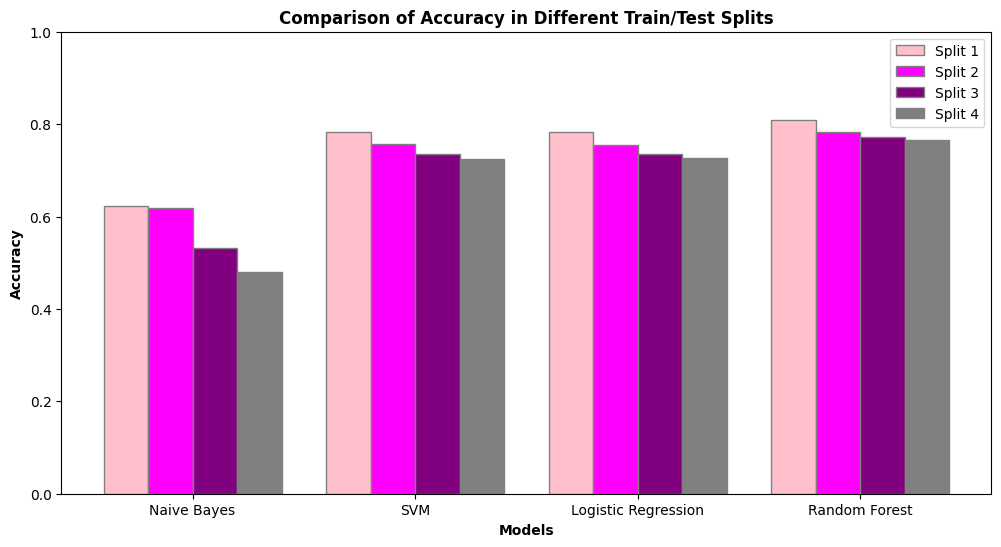

In [391]:


# Accuracy scores for each model in each train/test split
train_test_split_1 = [accNB_tfidf_1, accSVM_tfidf_1, acclm_tfidf_1, accrf_tfidf_1]
train_test_split_2 = [accNB_tfidf_2, accSVM_tfidf_2, acclm_tfidf_2, accrf_tfidf_2]
train_test_split_3 = [accNB_tfidf_3, accSVM_tfidf_3, acclm_tfidf_3, accrf_tfidf_3]
train_test_split_4 = [accNB_tfidf_4, accSVM_tfidf_4, acclm_tfidf_4, accrf_tfidf_4]

# Labels for models
models = ['Naive Bayes', 'SVM', 'Logistic Regression', 'Random Forest']

# Set the width of the bars
bar_width = 0.2

# Set position of bar on X axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Plotting accuracy scores for each train/test split
plt.figure(figsize=(12, 6))
plt.bar(r1, train_test_split_1, color='pink', width=bar_width, edgecolor='grey', label='Split 1')
plt.bar(r2, train_test_split_2, color='magenta', width=bar_width, edgecolor='grey', label='Split 2')
plt.bar(r3, train_test_split_3, color='purple', width=bar_width, edgecolor='grey', label='Split 3')
plt.bar(r4, train_test_split_4, color='grey', width=bar_width, edgecolor='grey', label='Split 4')

plt.xlabel('Models', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.xticks([r + 1.5 * bar_width for r in range(len(models))], models)
plt.title('Comparison of Accuracy in Different Train/Test Splits', fontweight='bold')
plt.legend()
plt.ylim(0, 1)  # Setting y-axis limit to be between 0 and 1 for better visualization
plt.show()


#Comparing BOW against TF-IDF

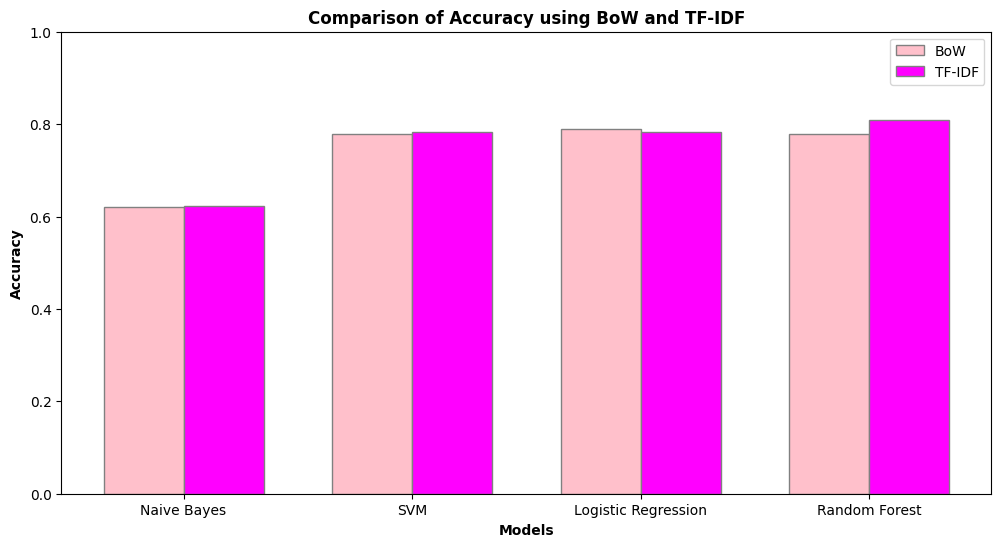

In [392]:
# Accuracy scores for different models using BoW
accuracy_scores_bow = [accNB_1, accSVM_1, acclm_1, accrf_1]

# Accuracy scores for different models using TF-IDF
accuracy_scores_tfidf = [accNB_tfidf_1, accSVM_tfidf_1, acclm_tfidf_1, accrf_tfidf_1]

# Model names
models = ['Naive Bayes', 'SVM', 'Logistic Regression', 'Random Forest']

# Set the width of the bars
bar_width = 0.35

# Set position of bar on X axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]

# Plotting accuracy scores for both BoW and TF-IDF
plt.figure(figsize=(12, 6))
plt.bar(r1, accuracy_scores_bow, color='pink', width=bar_width, edgecolor='grey', label='BoW')
plt.bar(r2, accuracy_scores_tfidf, color='magenta', width=bar_width, edgecolor='grey', label='TF-IDF')

plt.xlabel('Models', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(models))], models)
plt.title('Comparison of Accuracy using BoW and TF-IDF', fontweight='bold')
plt.legend()
plt.ylim(0, 1)  # Setting y-axis limit to be between 0 and 1 for better visualization
plt.show()
